# Analyzing wind and stress measurements from IRGASON

## Experiment parameters

* Date: 2019-12-03
* Tank: SUSTAIN
* Start time: 17:30 UTC
* Wind only, no paddle
* Fan from 0 to 60 Hz in 5 Hz intervals, each run 600 s (10 minutes)
* Fresh water
* Mean water depth: 0.8 m

**Note: Experiment stopped, last run being 50 Hz.**

## Loading the data

In [1]:
from datetime import datetime, timedelta
import glob
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import detrend
from sustain_drag_2020.irgason import read_irgason_from_toa5
import warnings
warnings.filterwarnings('ignore')

In [2]:
# data parameters
DATAPATH = '/home/milan/Work/sustain/data/sustain-nsf-2019/20191203'
irgason_files = glob.glob(DATAPATH + '/TOA5_SUSTAIN_Wind.FAST*.dat')

# experiment parameters
start_time = datetime(2019, 12, 3, 17, 30)
fan = range(0, 55, 5)
run_seconds = 600

In [3]:
# read IRGASON data from TOA5 files
time, irg1, irg2 = read_irgason_from_toa5(irgason_files)

Reading  TOA5_SUSTAIN_Wind.FAST_757_2019_12_03_1700.dat
Reading  TOA5_SUSTAIN_Wind.FAST_759_2019_12_03_1900.dat
Reading  TOA5_SUSTAIN_Wind.FAST_758_2019_12_03_1800.dat
Processing IRGASON time series..


In [4]:
irg1

{'u': array([-0.3060619, -0.319196 , -0.3164509, ..., 30.79647  , 30.72067  ,
        31.79161  ]),
 'v': array([-0.02478246, -0.03264296, -0.06298158, ...,  2.639949  ,
         1.528635  ,  1.968651  ]),
 'w': array([-1.314799e-02, -6.610319e-04, -8.852378e-03, ...,  1.998429e-01,
         2.470216e-01, -1.113438e+00]),
 'T': array([20.30649, 20.27336, 20.26609, ..., 20.38582, 20.74181, 22.50567])}

In [5]:
irg2

{'u': array([-0.2148253, -0.2000159, -0.1728828, ..., 33.00453  , 33.07967  ,
        35.24781  ]),
 'v': array([-0.0774193 , -0.07774182, -0.06512741, ..., -0.0397936 ,
         0.1062318 ,  0.4010925 ]),
 'w': array([0.04636998, 0.04969962, 0.05670616, ..., 0.6867825 , 0.6487083 ,
        1.439288  ]),
 'T': array([20.62396, 20.64276, 20.62772, ..., 21.94329, 21.89255, 23.44193])}

## Raw velocity data

Text(0.5, 1.0, 'u-component of wind, IRGASON 1')

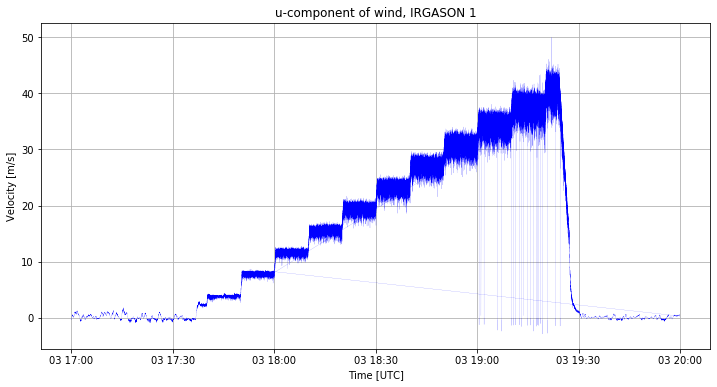

In [6]:
fig = plt.figure(figsize=(12, 6))
plt.plot(time, irg1['u'], 'b-', lw=0.1)
plt.grid()
plt.xlabel('Time [UTC]')
plt.ylabel('Velocity [m/s]')
plt.title('u-component of wind, IRGASON 1')

This is raw u-velocity (along-tank direction), from IRGASON 1 (short fetch). Comments:

* Some dropouts in data first appear at the beginning of the 50 Hz run, and some more at 55 and 60 Hz
* Mean wind seems to have a small negative trend, especially in higher winds. Perhaps due to water loss in the tank -- less water -> more air -> wind weakens over time?

Text(0.5, 1.0, 'v-component of wind, IRGASON 1')

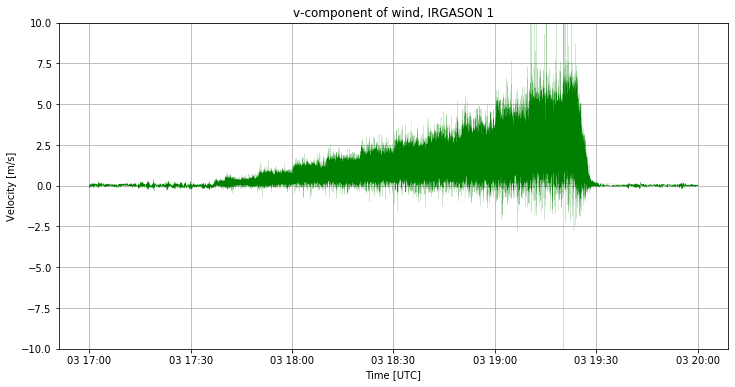

In [7]:
fig = plt.figure(figsize=(12, 6))
plt.plot(time, irg1['v'], 'g-', lw=0.1)
plt.grid()
plt.xlabel('Time [UTC]')
plt.ylabel('Velocity [m/s]')
plt.ylim(-10, 10)
plt.title('v-component of wind, IRGASON 1')

Raw values of cross-tank velocity.

* Mean is biased and positive, which means the instrument is not perfectly aligned in the along-tank direction. This is fine -- cross-tank velocity will go into the horizontal velocity. 
* Yes, some dropouts in the data here as well, although the values are less extreme than in the along-tank component.

Text(0.5, 1.0, 'w-component of wind, IRGASON 1')

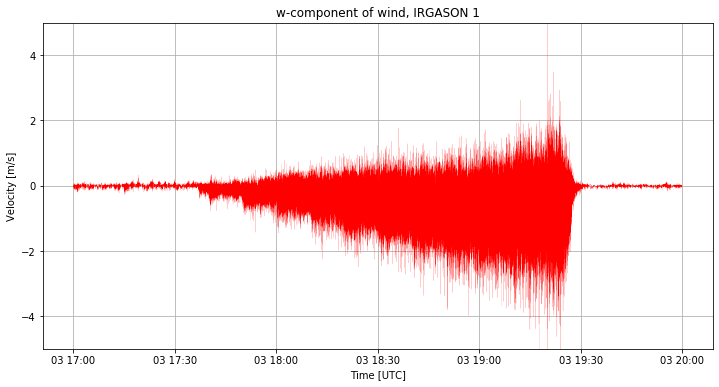

In [8]:
fig = plt.figure(figsize=(12, 6))
plt.plot(time, irg1['w'], 'r-', lw=0.1)
plt.grid()
plt.xlabel('Time [UTC]')
plt.ylabel('Velocity [m/s]')
plt.ylim(-5, 5)
plt.title('w-component of wind, IRGASON 1')

## Cleaning up and rotating the data

We can perform some basic cleaning of the data by setting some a priori maximum gust values and limiting the data at each fan speed to +/- gust range from the mean. This takes care of extreme velocities due to spray but is not ideal.

In [9]:
def rotate(u, w, th):
    """Rotates the vector (u, w) by angle th."""
    ur =  np.cos(th) * u + np.sin(th) * w
    wr = -np.sin(th) * u + np.cos(th) * w
    return ur, wr

In [10]:
def momentum_flux(irg, time, t0, t1):
    U, Ustd, Wstd, uw = [], [], [], []
    max_u_gust = 10
    max_w_gust = 5
    for n in range(len(fan)):
        mask = (time >= t0[n]) & (time <= t1[n])
        u, v, w = irg['u'][mask][:], irg['v'][mask][:], irg['w'][mask][:]

        # clean up
        um, vm, wm = np.nanmean(u), np.nanmean(v), np.nanmean(w)
        u[u > um + max_u_gust] = um + max_u_gust
        u[u < um - max_u_gust] = um - max_u_gust
        v[v > vm + max_u_gust] = vm + max_u_gust
        v[v < vm - max_u_gust] = vm - max_u_gust
        w[w > wm + max_w_gust] = wm + max_w_gust
        w[w < wm - max_w_gust] = wm - max_w_gust
        
        # horizontal velocity
        u = np.sqrt(u**2 + v**2)
        
        # rotate
        angle = np.arctan2(np.nanmean(w), np.nanmean(u))
        u, w = rotate(u, w, angle)

        # time average
        um, wm = np.nanmean(u), np.nanmean(w)

        up, wp = u - um, w - wm
        U.append(um)
        Ustd.append(np.nanstd(u))
        Wstd.append(np.nanstd(w))
        uw.append(np.nanmean(up * wp))

    return np.array(U), np.array(Ustd), np.array(Wstd), np.array(uw)

In [11]:
# 9-minute time windows for each run; 
# we exclude the first minute (thus 9 and not 10) due to fan spinup
t0 = [start_time + timedelta(seconds=n * run_seconds + 60)
    for n in range(len(fan))]
t1 = [start_time + timedelta(seconds=(n + 1) * run_seconds)
    for n in range(len(fan))]

In [12]:
U1, Ustd1, Wstd1, uw1 = momentum_flux(irg1, time, t0, t1)
U2, Ustd2, Wstd2, uw2 = momentum_flux(irg2, time, t0, t1)

Text(0.5, 1.0, 'Mean wind speed vs. fan')

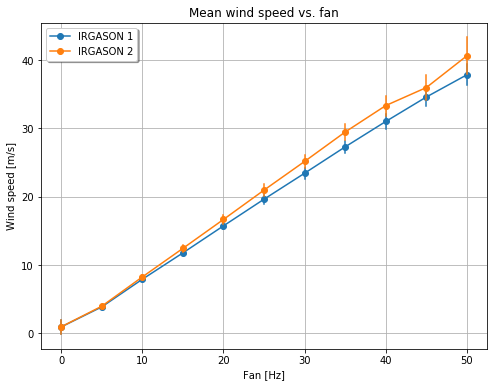

In [13]:
fig = plt.figure(figsize=(8, 6))
plt.plot(fan, U1, color='tab:blue', marker='o', label='IRGASON 1')
for n in range(U1.size):
    plt.plot([fan[n], fan[n]], [U1[n]-Ustd1[n], U1[n]+Ustd1[n]], color='tab:blue')
plt.plot(fan, U2, color='tab:orange', marker='o', label='IRGASON 2')
for n in range(U2.size):
    plt.plot([fan[n], fan[n]], [U2[n]-Ustd2[n], U2[n]+Ustd2[n]], color='tab:orange')
plt.legend(loc='upper left', fancybox=True, shadow=True)
plt.grid()
plt.xlabel('Fan [Hz]')
plt.ylabel('Wind speed [m/s]')
plt.title('Mean wind speed vs. fan')

In [14]:
# exclude 0 Hz data and some questionable data in high winds
uw1[0] = np.nan
uw2[0] = np.nan
uw2[-1:] = np.nan

Text(0.5, 1.0, 'Stress vs. mean wind speed')

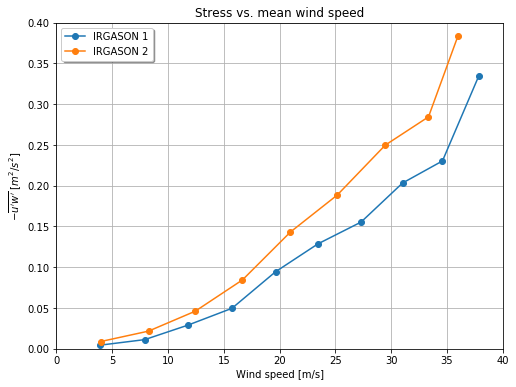

In [15]:
fig = plt.figure(figsize=(8, 6))
plt.plot(U1, uw1, color='tab:blue', marker='o', label='IRGASON 1')
plt.plot(U2, uw2, color='tab:orange', marker='o', label='IRGASON 2')
plt.legend(loc='upper left', fancybox=True, shadow=True)
plt.grid()
plt.xlim(0, 40)
plt.ylim(0, 0.4)
plt.xlabel('Wind speed [m/s]')
plt.ylabel(r"$-\overline{u'w'}$ [$m^2/s^2$]")
plt.title('Stress vs. mean wind speed')